# Import Libraries

In [75]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load data

In [76]:
#Đổi lại đường dẫn chứa thư mục tập train và tập test
train_path = 'D:\Document\\University\CS231\Baitap1\HoaVietNam\HoaVietNam\\train'
test_path = 'D:\Document\\University\CS231\Baitap1\HoaVietNam\HoaVietNam\\test'

In [77]:
def calc_histogram(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    feature = []
    hist = cv2.calcHist([image], [0, 1, 2], None, (32, 32, 32), [0, 256, 0, 256, 0, 256])
    feature.extend(hist.flatten())
    return np.array(feature)

In [78]:
def calc_histogram_2(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    feature = []
    hist = cv2.calcHist([image], [0, 1, 2], None, (16, 16, 16), [0, 256, 0, 256, 0, 256])
    feature.extend(hist.flatten())
    return np.array(feature)

In [79]:
def extract_color_moments(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean = np.mean(hsv, axis=(0, 1))
    std = np.std(hsv, axis=(0, 1))
    skewness = np.mean(((hsv - mean) / (std + 1e-6)) ** 3, axis=(0, 1))
    return np.concatenate([mean, std, skewness])

In [80]:
def extract_dominant_color(image, k=3):
    pixels = image.reshape(-1, 3)
    kmeans = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centers = cv2.kmeans(np.float32(pixels), k, None,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
    10, kmeans)
    hist = np.bincount(labels.flatten(), minlength=k) / labels.size
    return np.hstack([centers.flatten(), hist])

In [81]:
def preprocessing_image(img, image_type='calc_histogram'):
    if image_type == 'calc_histogram':
        img = calc_histogram(img)
    elif image_type == 'calc_histogram_2':
        img = calc_histogram_2(img)
    elif image_type == 'extract_color_moments':
        img = extract_color_moments(img)
    elif image_type == 'extract_dominant_color':
        img = extract_dominant_color(img)
    return img

In [82]:
def get_data_set(image_type='calc_histogram'):
    labels = os.listdir(train_path)
    label_to_number = {label: idx + 1 for idx, label in enumerate(labels)}

    X_train, X_test, Y_train, Y_test = [], [], [], []
    image_test_paths = []
    for label in labels:
        train_images_list = os.listdir(os.path.join(train_path, label))
        test_images_list = os.listdir(os.path.join(test_path, label))

        for img_name in train_images_list:
            img = cv2.imread(os.path.join(train_path, label, img_name))
            img = preprocessing_image(img, image_type)

            X_train.append(img)
            Y_train.append(label_to_number[label])

        for img_name in test_images_list:
            img = cv2.imread(os.path.join(test_path, label, img_name))
            img = preprocessing_image(img, image_type)

            X_test.append(img)
            Y_test.append(label_to_number[label])
            
            image_test_paths.append(os.path.join(test_path, label, img_name))

    return np.array(X_train), np.array(Y_train).reshape(-1),  np.array(X_test), np.array(Y_test).reshape(-1), image_test_paths

In [83]:
def train_model(X_train, Y_train, X_test, Y_test, n_neighbors=7, weights='uniform', metric='braycurtis'):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(X_train, Y_train)

    predictions = model.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions)
    return accuracy, model

In [84]:
weights_list = ['uniform', 'distance']
metric_list = ['braycurtis', 'canberra', 'correlation', 'cosine', 'euclidean', 'minkowski']

max_accuracy = 0
best_weights, best_metric = '', ''

X_train, Y_train, X_test, Y_test, _ = get_data_set(image_type='calc_histogram')

In [85]:
for weights in weights_list:
    for metric in metric_list:
        accuracy, _ = train_model(X_train, Y_train, X_test, Y_test, weights=weights, metric=metric)
        print(f'With weight: {weights}, metric: {metric} -> Accuracy: {accuracy}')

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_weights, best_metric = weights, metric

print("_____Conclusion_____")
print(f"Best weights: {best_weights}")
print(f"Best metric: {best_metric}")
print(f"Accuracy: {max_accuracy}")

With weight: uniform, metric: braycurtis -> Accuracy: 0.92
With weight: uniform, metric: canberra -> Accuracy: 0.74
With weight: uniform, metric: correlation -> Accuracy: 0.86
With weight: uniform, metric: cosine -> Accuracy: 0.86
With weight: uniform, metric: euclidean -> Accuracy: 0.54
With weight: uniform, metric: minkowski -> Accuracy: 0.54
With weight: distance, metric: braycurtis -> Accuracy: 0.94
With weight: distance, metric: canberra -> Accuracy: 0.8
With weight: distance, metric: correlation -> Accuracy: 0.84
With weight: distance, metric: cosine -> Accuracy: 0.84
With weight: distance, metric: euclidean -> Accuracy: 0.6
With weight: distance, metric: minkowski -> Accuracy: 0.6
_____Conclusion_____
Best weights: distance
Best metric: braycurtis
Accuracy: 0.94


# Yêu cầu 1

In [97]:
# Moment màu
print("Loading Data......")
X_train, Y_train, X_test, Y_test, _ = get_data_set(image_type='extract_color_moments')

Loading Data......


In [96]:
print("Starting Trainning Model...")
accuracy, _ = train_model(X_train, Y_train, X_test, Y_test, weights=best_weights, metric=best_metric)
print(f"Using extract_color_moment, weights={best_weights}, metric={best_metric} -> accuracy = ", accuracy) 

Starting Trainning Model...
Using extract_color_moment, weights=distance, metric=braycurtis -> accuracy =  0.56


In [88]:
# Màu chủ đạo trong ảnh
print("Loading Data......")
X_train, Y_train, X_test, Y_test, _ = get_data_set(image_type='extract_dominant_color')

Loading Data......


In [89]:
print("Starting Trainning Model...")
accuracy, _ = train_model(X_train, Y_train, X_test, Y_test, weights=best_weights, metric=best_metric)
print(f"Using extract_dominant_color, weights={best_weights}, metric={best_metric} -> accuracy = ", accuracy) 

Starting Trainning Model...
Using extract_dominant_color, weights=distance, metric=braycurtis -> accuracy =  0.56


# Yêu cầu 2

In [90]:
X_train1, Y_train1, X_test1, Y_test1, image_test_path = get_data_set(image_type='calc_histogram')
accuracy1, model1 = train_model(X_train1, Y_train1, X_test1, Y_test1, weights=best_weights, metric=best_metric)

X_train2, Y_train2, X_test2, Y_test2, _ = get_data_set(image_type='calc_histogram_2')
accuracy2, model2 = train_model(X_train2, Y_train2, X_test2, Y_test2, weights=best_weights, metric=best_metric)

print("With bin=(16, 16, 16) -> Accuracy =", accuracy2)

With bin=(16, 16, 16) -> Accuracy = 0.92


In [91]:
predict1 = model1.predict(X_test1)
answer1 = Y_test1 == predict1

predict2 = model2.predict(X_test2)
answer2 = Y_test2 == predict2

In [92]:
def show_images(image_list, title):
    if not image_list:
        print(f"No images found for: {title}")
        return
    fig, axes = plt.subplots(1, min(5, len(image_list)), figsize=(15, 5))
    if len(image_list) == 1:
        axes = [axes]
    for ax, img_path in zip(axes, image_list[:5]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(img_path))
    plt.suptitle(title)
    plt.show()

In [93]:
F_T = []
for i, path in enumerate(image_test_path):
    if answer1[i] == False and answer2[i] == True:
        F_T.append(path)

show_images(F_T, 'Misclassified by RGB-32-bin but Correct by HSV-16-bin')

No images found for: Misclassified by RGB-32-bin but Correct by HSV-16-bin


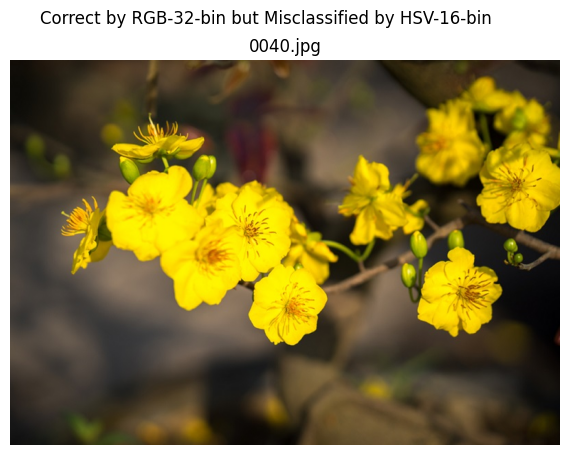

In [94]:
T_F = []
for i, path in enumerate(image_test_path):
    if answer1[i] == True and answer2[i] == False:
        T_F.append(path)

show_images(T_F, 'Correct by RGB-32-bin but Misclassified by HSV-16-bin')

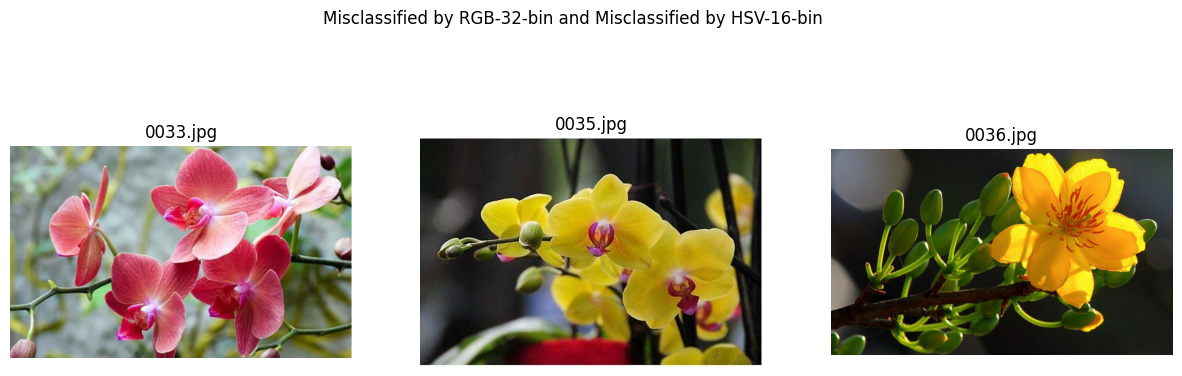

In [95]:
F_F = []
for i, path in enumerate(image_test_path):
    if answer1[i] == False and answer2[i] == False:
        F_F.append(path)

show_images(F_F, 'Misclassified by RGB-32-bin and Misclassified by HSV-16-bin')